In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    channel_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        49280     
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2048000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                32768016  
Total params: 32,817,808
Trainable params: 32,817,808
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 128)         49280     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 128)         49280     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 128)         49280     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 128)         49280     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9805 - acc: 0.3597
Epoch 00001: val_loss improved from inf to 1.45919, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_4_conv_checkpoint/001-1.4592.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.9804 - acc: 0.3598 - val_loss: 1.4592 - val_acc: 0.5292
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2934 - acc: 0.5961
Epoch 00002: val_loss improved from 1.45919 to 1.17337, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_4_conv_checkpoint/002-1.1734.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 1.2934 - acc: 0.5961 - val_loss: 1.1734 - val_acc: 0.6471
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0061 - acc: 0.6943
Epoch 00003: val_loss improved from 1.17337 t

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9835
Epoch 00028: val_loss did not improve from 0.97897
36805/36805 [==============================] - 101s 3ms/sample - loss: 0.0598 - acc: 0.9835 - val_loss: 1.4015 - val_acc: 0.7447
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9819
Epoch 00029: val_loss did not improve from 0.97897
36805/36805 [==============================] - 101s 3ms/sample - loss: 0.0636 - acc: 0.9819 - val_loss: 1.5635 - val_acc: 0.7452
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9833
Epoch 00030: val_loss did not improve from 0.97897
36805/36805 [==============================] - 101s 3ms/sample - loss: 0.0588 - acc: 0.9833 - val_loss: 1.4922 - val_acc: 0.7643
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9841
Epoch 00031: val_loss did not improve from 0.97897
36805/36805 [========

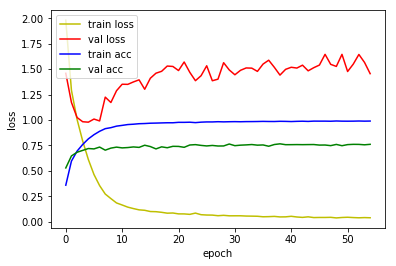

4815/4815 [==============================] - 11s 2ms/sample - loss: 1.0946 - acc: 0.6825
Loss: 1.094621503080782 Accuracy: 0.68245065

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9554 - acc: 0.3641
Epoch 00001: val_loss improved from inf to 1.36096, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_5_conv_checkpoint/001-1.3610.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.9553 - acc: 0.3641 - val_loss: 1.3610 - val_acc: 0.5651
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2928 - acc: 0.5907
Epoch 00002: val_loss improved from 1.36096 to 1.13281, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_5_conv_checkpoint/002-1.1328.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.2927 - acc: 0.5908 - val_loss: 1.1328 - val_acc: 0.6464
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9819
Epoch 00027: val_loss did not improve from 0.63804
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0601 - acc: 0.9819 - val_loss: 0.8281 - val_acc: 0.8467
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0621 - acc: 0.9819
Epoch 00028: val_loss did not improve from 0.63804
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0621 - acc: 0.9819 - val_loss: 0.8482 - val_acc: 0.8321
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0621 - acc: 0.9821
Epoch 00029: val_loss did not improve from 0.63804
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0621 - acc: 0.9821 - val_loss: 0.8795 - val_acc: 0.8432
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9854
Epoch 00030: val_loss did not improve from 0.63804
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9899
Epoch 00057: val_loss did not improve from 0.63804
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0373 - acc: 0.9899 - val_loss: 0.8537 - val_acc: 0.8579

1D_CNN_custom_conv_3_VGG_ch_128_DO_5_conv Model


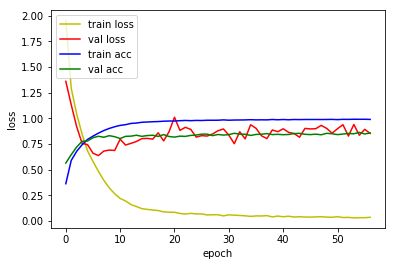

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.7625 - acc: 0.7769
Loss: 0.7625076849760173 Accuracy: 0.776947

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1040 - acc: 0.3122
Epoch 00001: val_loss improved from inf to 1.40235, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_6_conv_checkpoint/001-1.4023.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 2.1040 - acc: 0.3122 - val_loss: 1.4023 - val_acc: 0.5637
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3887 - acc: 0.5545
Epoch 00002: val_loss improved from 1.40235 to 1.22103, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_6_conv_checkpoint/002-1.2210.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.3887 - acc: 0.5545 - val_loss: 1.2210 - val_acc: 0.6252
Epoch 3/500
36800/36805 [============================>.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1023 - acc: 0.9659
Epoch 00025: val_loss did not improve from 0.30766
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1023 - acc: 0.9659 - val_loss: 0.3348 - val_acc: 0.9278
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9691
Epoch 00026: val_loss did not improve from 0.30766
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0967 - acc: 0.9691 - val_loss: 0.3557 - val_acc: 0.9180
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9695
Epoch 00027: val_loss did not improve from 0.30766
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0938 - acc: 0.9695 - val_loss: 0.4047 - val_acc: 0.9187
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9721
Epoch 00028: val_loss did not improve from 0.30766
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9885
Epoch 00055: val_loss did not improve from 0.30766
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0377 - acc: 0.9885 - val_loss: 0.4328 - val_acc: 0.9266
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9905
Epoch 00056: val_loss did not improve from 0.30766
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0301 - acc: 0.9905 - val_loss: 0.4316 - val_acc: 0.9311
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9890
Epoch 00057: val_loss did not improve from 0.30766
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0379 - acc: 0.9890 - val_loss: 0.4158 - val_acc: 0.9287
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9899
Epoch 00058: val_loss did not improve from 0.30766
36805/36805 [========

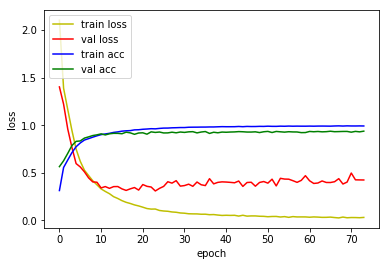

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.3721 - acc: 0.9011
Loss: 0.37210325110986103 Accuracy: 0.90114224

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2670 - acc: 0.2445
Epoch 00001: val_loss improved from inf to 1.43495, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_7_conv_checkpoint/001-1.4349.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 2.2669 - acc: 0.2445 - val_loss: 1.4349 - val_acc: 0.5383
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3307 - acc: 0.5589
Epoch 00002: val_loss improved from 1.43495 to 1.04387, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_7_conv_checkpoint/002-1.0439.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.3308 - acc: 0.5588 - val_loss: 1.0439 - val_acc: 0.6625
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9653
Epoch 00024: val_loss did not improve from 0.16585
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.1069 - acc: 0.9653 - val_loss: 0.1762 - val_acc: 0.9546
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9657
Epoch 00025: val_loss did not improve from 0.16585
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.1057 - acc: 0.9657 - val_loss: 0.1760 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9698
Epoch 00026: val_loss did not improve from 0.16585
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0932 - acc: 0.9698 - val_loss: 0.1785 - val_acc: 0.9529
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9704
Epoch 00027: val_loss did not improve from 0.16585
36805/36805 [=====================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9881
Epoch 00053: val_loss did not improve from 0.15797
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0377 - acc: 0.9881 - val_loss: 0.1903 - val_acc: 0.9571
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9876
Epoch 00054: val_loss did not improve from 0.15797
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0372 - acc: 0.9876 - val_loss: 0.1961 - val_acc: 0.9595
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9895
Epoch 00055: val_loss did not improve from 0.15797
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0310 - acc: 0.9895 - val_loss: 0.2236 - val_acc: 0.9557
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9879
Epoch 00056: val_loss did not improve from 0.15797
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9934
Epoch 00083: val_loss did not improve from 0.15797
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0207 - acc: 0.9934 - val_loss: 0.2402 - val_acc: 0.9574

1D_CNN_custom_conv_3_VGG_ch_128_DO_7_conv Model


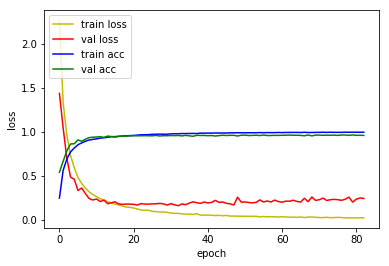

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2035 - acc: 0.9443
Loss: 0.2035303854187206 Accuracy: 0.9443406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4215 - acc: 0.2027
Epoch 00001: val_loss improved from inf to 1.67682, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_8_conv_checkpoint/001-1.6768.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 2.4215 - acc: 0.2027 - val_loss: 1.6768 - val_acc: 0.4619
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2551 - acc: 0.5874
Epoch 00002: val_loss improved from 1.67682 to 0.71508, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_8_conv_checkpoint/002-0.7151.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.2551 - acc: 0.5874 - val_loss: 0.7151 - val_acc: 0.7806
Epoch 3/500
36800/36805 [============================>

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0797 - acc: 0.9724
Epoch 00024: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0797 - acc: 0.9724 - val_loss: 0.1124 - val_acc: 0.9697
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9751
Epoch 00025: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0743 - acc: 0.9751 - val_loss: 0.1329 - val_acc: 0.9655
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9755
Epoch 00026: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0737 - acc: 0.9755 - val_loss: 0.1089 - val_acc: 0.9690
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9764
Epoch 00027: val_loss did not improve from 0.10445
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9912
Epoch 00054: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0265 - acc: 0.9913 - val_loss: 0.1489 - val_acc: 0.9665
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9914
Epoch 00055: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0276 - acc: 0.9914 - val_loss: 0.1407 - val_acc: 0.9702
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.10445
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0237 - acc: 0.9920 - val_loss: 0.1321 - val_acc: 0.9718
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9915
Epoch 00057: val_loss did not improve from 0.10445
36805/36805 [========

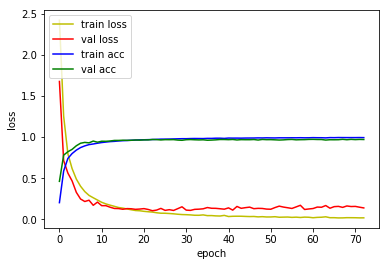

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1582 - acc: 0.9570
Loss: 0.15822456661584716 Accuracy: 0.9570094

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0728 - acc: 0.3237
Epoch 00001: val_loss improved from inf to 1.19666, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_9_conv_checkpoint/001-1.1967.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 2.0727 - acc: 0.3238 - val_loss: 1.1967 - val_acc: 0.6245
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9728 - acc: 0.6819
Epoch 00002: val_loss improved from 1.19666 to 0.60869, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_9_conv_checkpoint/002-0.6087.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.9728 - acc: 0.6819 - val_loss: 0.6087 - val_acc: 0.7973
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9821
Epoch 00026: val_loss did not improve from 0.13756
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0547 - acc: 0.9821 - val_loss: 0.1487 - val_acc: 0.9658
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9870
Epoch 00027: val_loss improved from 0.13756 to 0.13588, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_9_conv_checkpoint/027-0.1359.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0405 - acc: 0.9870 - val_loss: 0.1359 - val_acc: 0.9669
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9873
Epoch 00028: val_loss did not improve from 0.13588
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0392 - acc: 0.9873 - val_loss: 0.1895 - val_acc: 0.9585
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9948
Epoch 00055: val_loss did not improve from 0.13588
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0174 - acc: 0.9948 - val_loss: 0.2046 - val_acc: 0.9585
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.13588
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0191 - acc: 0.9940 - val_loss: 0.1483 - val_acc: 0.9695
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9950
Epoch 00057: val_loss did not improve from 0.13588
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0170 - acc: 0.9950 - val_loss: 0.2202 - val_acc: 0.9630
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9945
Epoch 00058: val_loss did not improve from 0.13588
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9961
Epoch 00084: val_loss did not improve from 0.12759
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0122 - acc: 0.9961 - val_loss: 0.2033 - val_acc: 0.9632
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9966
Epoch 00085: val_loss did not improve from 0.12759
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0119 - acc: 0.9966 - val_loss: 0.1824 - val_acc: 0.9695
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9965
Epoch 00086: val_loss did not improve from 0.12759
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0127 - acc: 0.9965 - val_loss: 0.1681 - val_acc: 0.9674
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9976
Epoch 00087: val_loss did not improve from 0.12759
36805/36805 [=====================

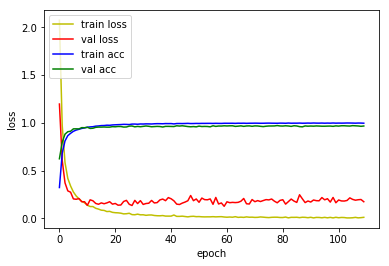

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2249 - acc: 0.9549
Loss: 0.22492090308500082 Accuracy: 0.9549325



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_128_DO'
    
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_DO_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1557904     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1582 - acc: 0.9570
Loss: 0.15822456661584716 Accuracy: 0.9570094

1D_CNN_custom_conv_3_VGG_ch_128_DO_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequentia

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_DO_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1557904     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1911 - acc: 0.9622
Loss: 0.19111805012529948 Accuracy: 0.9622015

1D_CNN_custom_conv_3_VGG_ch_128_DO_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequentia